In [177]:
import numpy as np
import pandas as pd

from utils.plots import plot_water_over_time


In [178]:
def estimar_volumes_para_multiplas_colunas(arquivo_areas, arquivo_cav):
    # 1. Carrega os dados
    df_areas = pd.read_csv(arquivo_areas)
    df_cav = pd.read_csv(arquivo_cav)

    # 2. Ordena e remove duplicatas na curva CAV
    df_cav = df_cav.sort_values("area").drop_duplicates(subset=["area"])

    # 3. Define limites da curva para evitar extrapolação
    min_area = df_cav["area"].min()
    max_area = df_cav["area"].max()

    # 4. Para cada coluna de área, gerar a coluna correspondente de volume
    colunas_area = df_areas.columns
    for coluna in colunas_area:
        # Garante que as áreas estejam dentro dos limites da CAV
        areas = df_areas[coluna].clip(lower=min_area, upper=max_area)

        # Interpola e converte para milhões de m³
        volumes = np.interp(areas, df_cav["area"], df_cav["volume"])
        df_areas[f"volume_{coluna}"] = volumes / 1e6  # volume em 10⁶ m³

    return df_areas


In [179]:
df_resultado = estimar_volumes_para_multiplas_colunas("./data/areas.csv", "./data/sume_cotas.csv")
df_resultado.to_csv("./data/volumes.csv", index=False)

In [180]:
df_resultado.head()

,m2_area_fmask_deepwatermap,km2_area_fmask_deepwatermap,m2_area_deepwatermap,km2_area_deepwatermap,km2_area_ndwi,m2_area_fmask_ndwi,km2_area_fmask_ndwi,m2_area_mndwi,km2_area_mndwi,m2_area_fmask_mndwi,...,volume_m2_area_fmask_ndwi,volume_km2_area_fmask_ndwi,volume_m2_area_mndwi,volume_km2_area_mndwi,volume_m2_area_fmask_mndwi,volume_km2_area_fmask_mndwi,volume_year,volume_month,volume_m2_area_ndwi,volume_CLOUDY_PIXEL_PERCENTAGE
0,4.735766e+06,4.735766,7.454560e+06,7.454560,0.087013,1.014202e+06,1.014202,2.543595e+06,2.543595,3.270280e+06,...,1.451281,3.042605e-07,6.221542,7.630785e-07,9.513460,9.810841e-07,0.000605,3.000000e-07,0.071821,9.835730e-06
1,4.675754e+06,4.675754,9.651077e+06,9.651077,0.000000,3.539655e+05,0.353965,2.446290e+07,24.462902,8.834444e+05,...,0.382107,1.061896e-07,44.864100,7.338870e-06,1.197408,2.650333e-07,0.000605,1.500000e-06,0.000000,2.591093e-05
2,3.807888e+06,3.807888,8.685063e+06,8.685063,0.000000,1.689022e+05,0.168902,1.319741e+07,13.197410,9.224372e+05,...,0.172424,5.067067e-08,44.864100,3.959223e-06,1.270682,2.767312e-07,0.000605,3.600000e-06,0.000000,2.410151e-05
3,1.168421e+06,1.168421,6.314420e+06,6.314420,0.135398,9.775832e+06,9.775832,8.700529e+05,0.870053,3.269877e+07,...,44.864100,2.932750e-06,1.172244,2.610159e-07,44.864100,9.809630e-06,0.000605,3.600000e-06,0.130391,8.341354e-06
4,3.709049e+06,3.709049,3.544877e+06,3.544877,0.270007,7.150654e+06,7.150654,8.182593e+05,0.818259,2.564726e+07,...,34.488342,2.145196e-06,1.074916,2.454778e-07,44.864100,7.694178e-06,0.000605,3.600000e-06,0.290487,3.030000e-09


In [181]:
df_resultado.describe()

,m2_area_fmask_deepwatermap,km2_area_fmask_deepwatermap,m2_area_deepwatermap,km2_area_deepwatermap,km2_area_ndwi,m2_area_fmask_ndwi,km2_area_fmask_ndwi,m2_area_mndwi,km2_area_mndwi,m2_area_fmask_mndwi,...,volume_m2_area_fmask_ndwi,volume_km2_area_fmask_ndwi,volume_m2_area_mndwi,volume_km2_area_mndwi,volume_m2_area_fmask_mndwi,volume_km2_area_fmask_mndwi,volume_year,volume_month,volume_m2_area_ndwi,volume_CLOUDY_PIXEL_PERCENTAGE
count,4.770000e+02,477.000000,4.800000e+02,480.000000,480.000000,4.770000e+02,477.000000,4.800000e+02,480.000000,4.770000e+02,...,477.000000,4.770000e+02,480.000000,4.800000e+02,477.000000,4.770000e+02,4.800000e+02,4.800000e+02,480.000000,4.800000e+02
mean,3.617533e+06,3.617533,7.258739e+06,7.258739,0.068048,4.797132e+06,4.797132,1.112518e+07,11.125184,1.608707e+07,...,20.516346,1.439140e-06,24.066922,3.337555e-06,32.307919,4.826122e-06,6.065200e-04,1.891250e-06,0.083541,1.374662e-05
std,1.416000e+06,1.416000,2.721252e+06,2.721252,0.197579,3.632094e+06,3.632094,1.151780e+07,11.517796,1.200026e+07,...,18.412239,1.089628e-06,19.519330,3.455339e-06,17.853211,3.600079e-06,5.743799e-07,1.054984e-06,0.290754,9.310892e-06
min,2.383748e+05,0.238375,0.000000e+00,0.000000,0.000000,1.842749e+04,0.018427,1.679844e+05,0.167984,2.491211e+05,...,0.011419,5.528247e-09,0.171273,5.039532e-08,0.267696,7.473632e-08,6.054000e-04,3.000000e-07,0.000000,8.850000e-11
25%,2.499438e+06,2.499438,5.119023e+06,5.119023,0.000000,1.233164e+06,1.233164,1.657271e+06,1.657271,3.614914e+06,...,2.037892,3.699491e-07,3.141552,4.971812e-07,11.593612,1.084474e-06,6.060000e-04,9.000000e-07,0.000000,5.507138e-06
50%,3.526056e+06,3.526056,8.484331e+06,8.484331,0.000000,4.363077e+06,4.363077,5.607144e+06,5.607144,1.469854e+07,...,16.111323,1.308923e-06,23.826045,1.682143e-06,44.864100,4.409561e-06,6.066000e-04,1.800000e-06,0.000000,1.364834e-05
75%,4.735766e+06,4.735766,9.775857e+06,9.775857,0.006602,9.034791e+06,9.034791,2.038741e+07,20.387409,2.947398e+07,...,44.864100,2.710437e-06,44.864100,6.116223e-06,44.864100,8.842193e-06,6.069000e-04,2.700000e-06,0.002585,2.193944e-05
max,7.555369e+06,7.555369,9.776029e+06,9.776029,1.604867,9.776029e+06,9.776029,3.269896e+07,32.698962,3.269896e+07,...,44.864100,2.932809e-06,44.864100,9.809689e-06,44.864100,9.809689e-06,6.075000e-04,3.600000e-06,3.010018,3.000000e-05


In [182]:
columns = [column for column in list(df_resultado.columns) if column.startswith("volume_m2")]

In [183]:
columns

['volume_m2_area_fmask_deepwatermap',
 'volume_m2_area_deepwatermap',
 'volume_m2_area_fmask_ndwi',
 'volume_m2_area_mndwi',
 'volume_m2_area_fmask_mndwi',
 'volume_m2_area_ndwi']

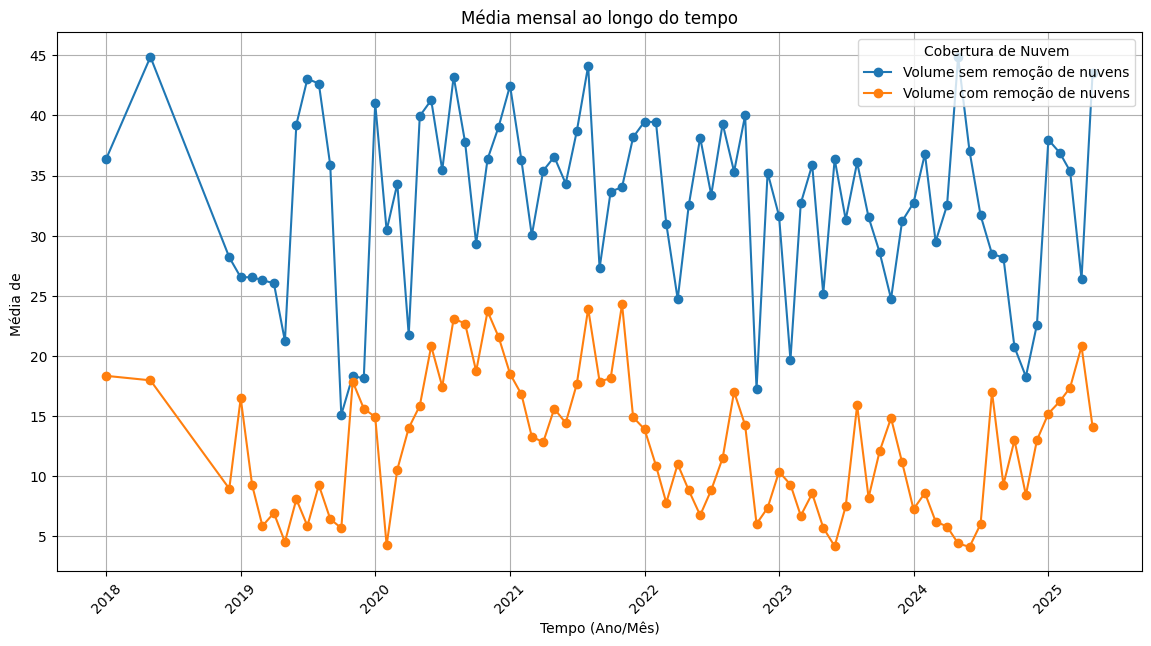

In [184]:
plot_water_over_time(
    df_resultado,
    y_variables=[
        "volume_m2_area_deepwatermap",
        "volume_m2_area_fmask_deepwatermap",
    ],
    labels=["Volume sem remoção de nuvens", "Volume com remoção de nuvens"],
)


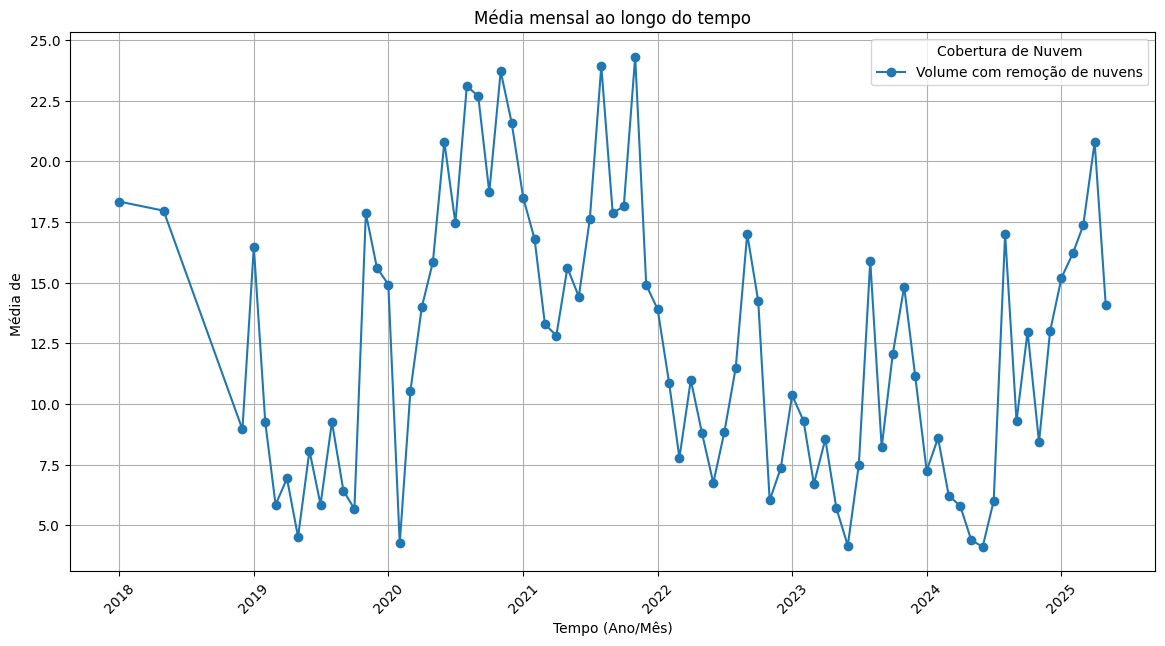

In [185]:
plot_water_over_time(
    df_resultado,
    y_variables=[
        "volume_m2_area_fmask_deepwatermap",
    ],
    labels=["Volume com remoção de nuvens"],
)


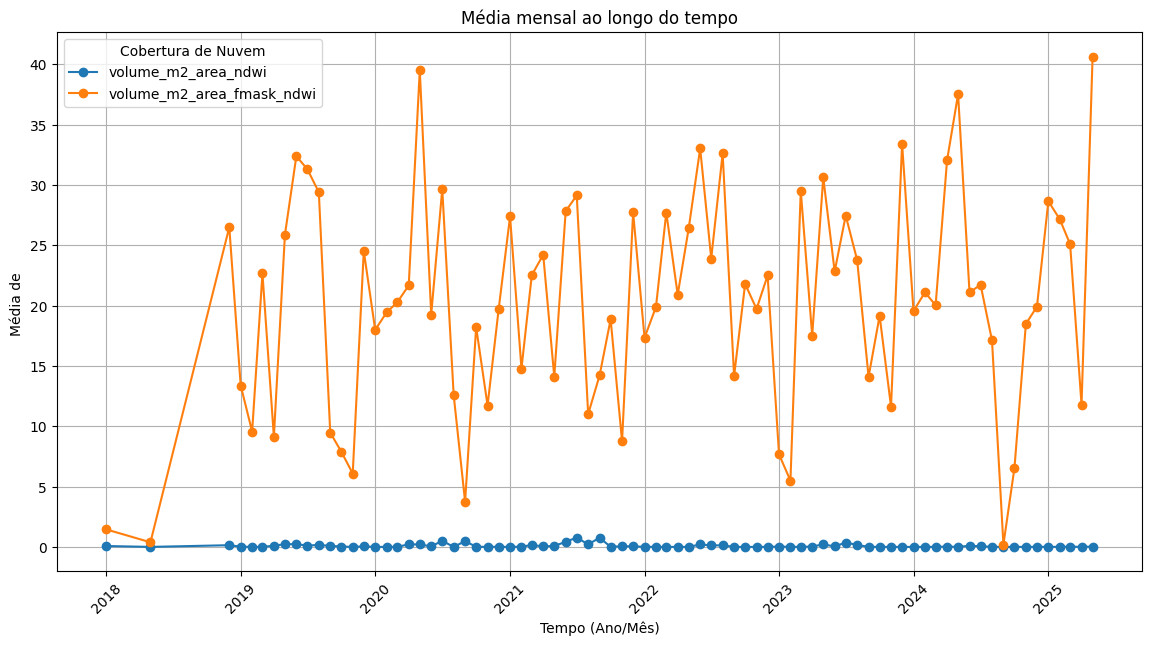

In [186]:
plot_water_over_time(
    df_resultado,
    y_variables=["volume_m2_area_ndwi", "volume_m2_area_fmask_ndwi"],
    labels=["volume_m2_area_ndwi", "volume_m2_area_fmask_ndwi"],
)


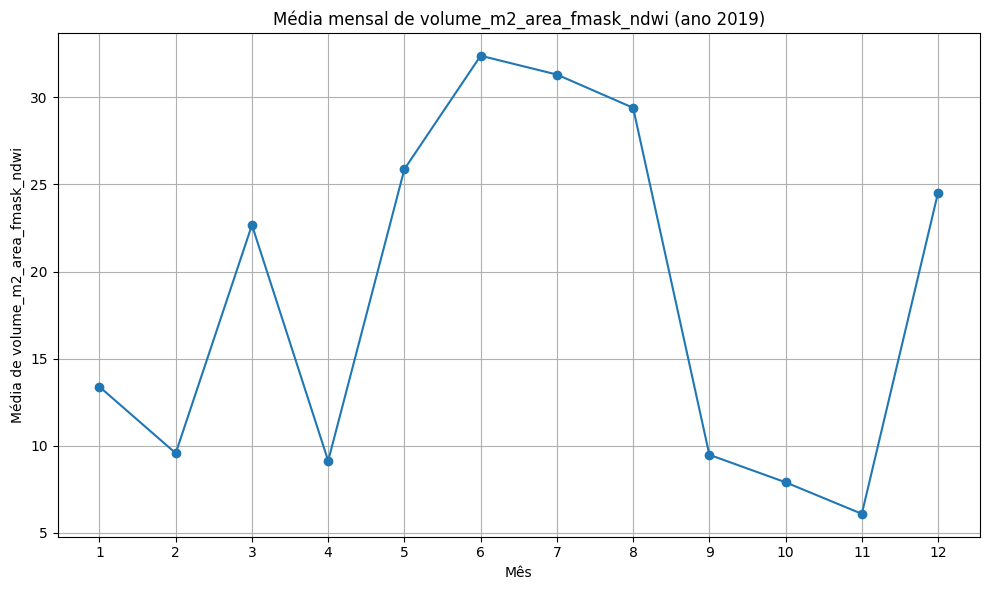

In [187]:
from utils.plots import plot_monthly_water


plot_monthly_water(df_resultado, year=2019, y_variable="volume_m2_area_fmask_ndwi")


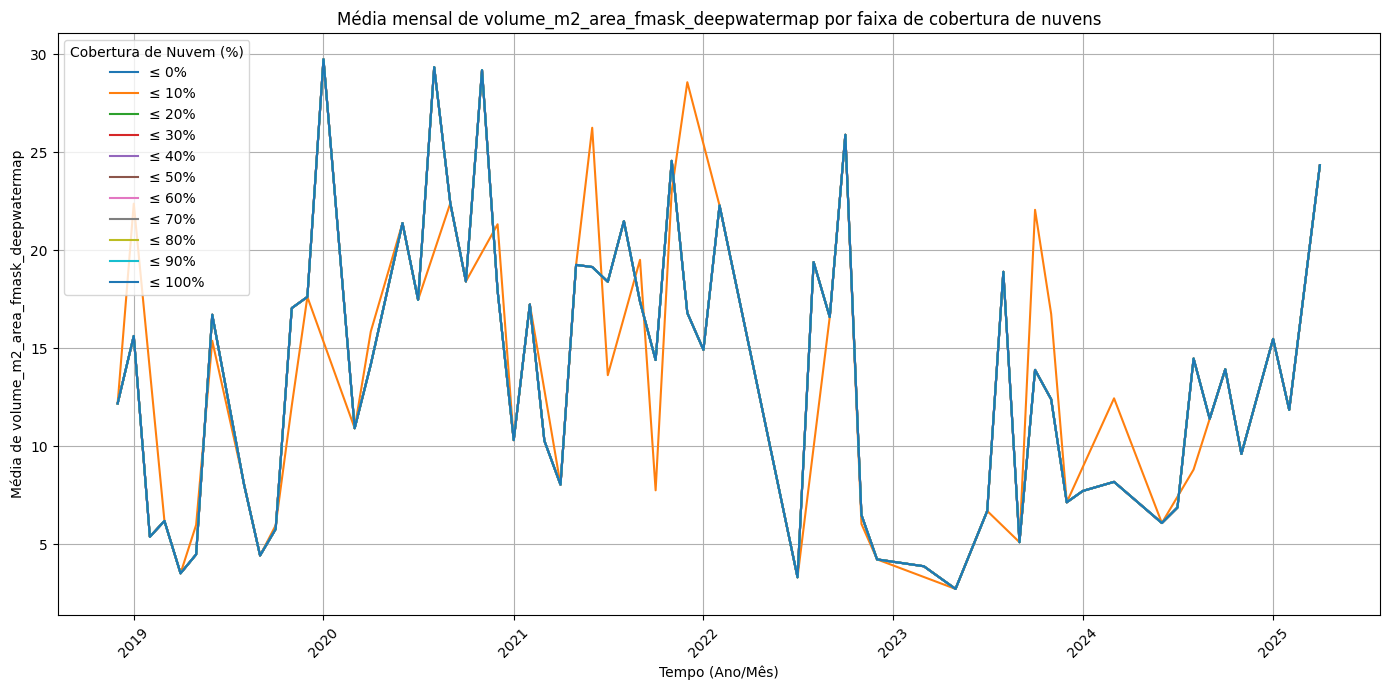

In [188]:
from utils.plots import plot_water_x_cloud_percent_over_time


plot_water_x_cloud_percent_over_time(
    df_resultado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 20],
    y_variable="volume_m2_area_fmask_deepwatermap",
)


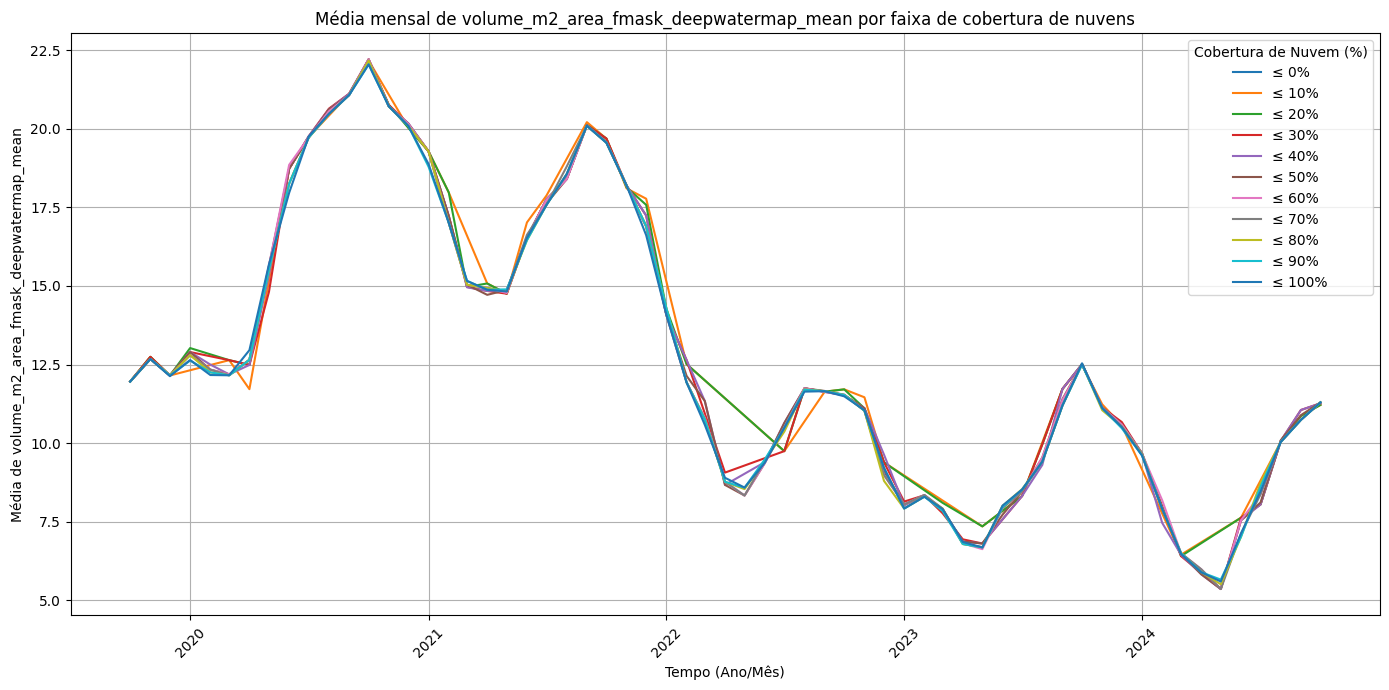

In [218]:
df_resultado["volume_m2_area_fmask_deepwatermap_mean"] = (
    df_resultado["volume_m2_area_fmask_deepwatermap"].rolling(window=30, center=True).mean()
)
plot_water_x_cloud_percent_over_time(
    df_resultado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 100],
    y_variable="volume_m2_area_fmask_deepwatermap_mean",
)


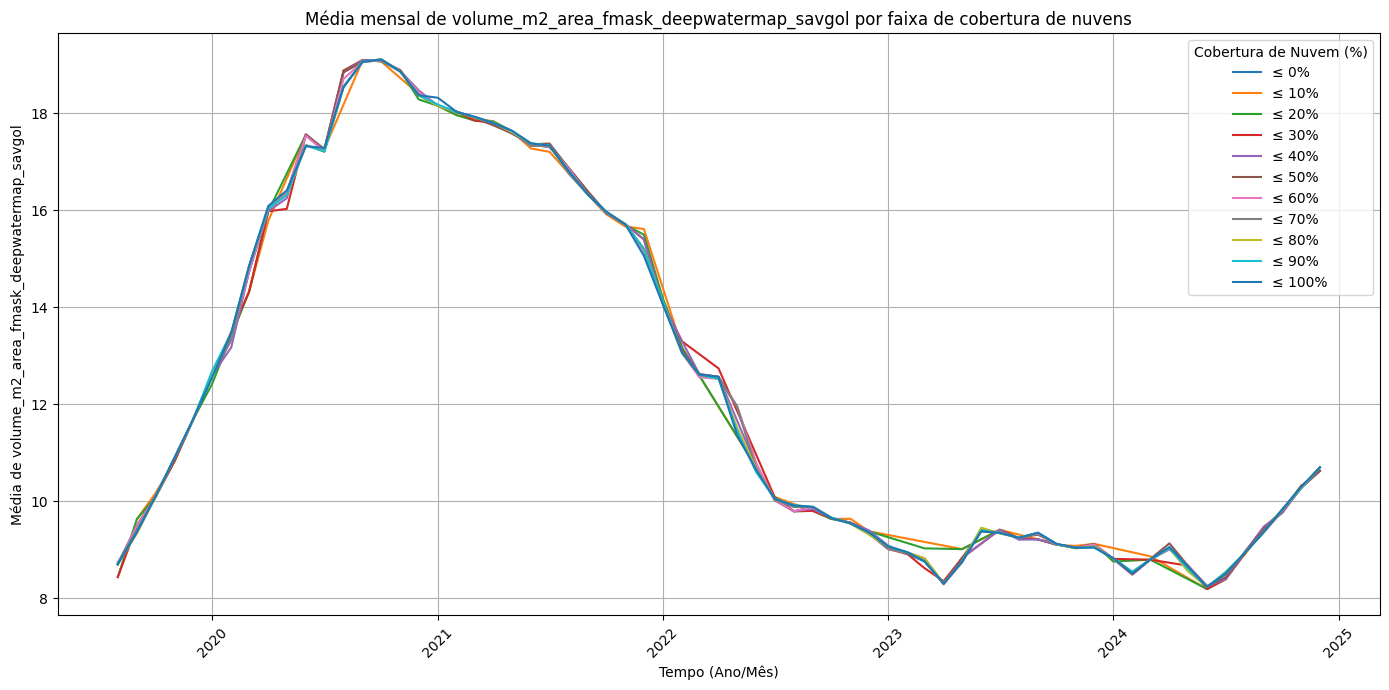

In [219]:
from scipy.signal import savgol_filter

df_resultado["volume_m2_area_fmask_deepwatermap_savgol"] = savgol_filter(
    df_resultado["volume_m2_area_fmask_deepwatermap"], window_length=70, polyorder=1
)

plot_water_x_cloud_percent_over_time(
    df_resultado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 100],
    y_variable="volume_m2_area_fmask_deepwatermap_savgol",
)


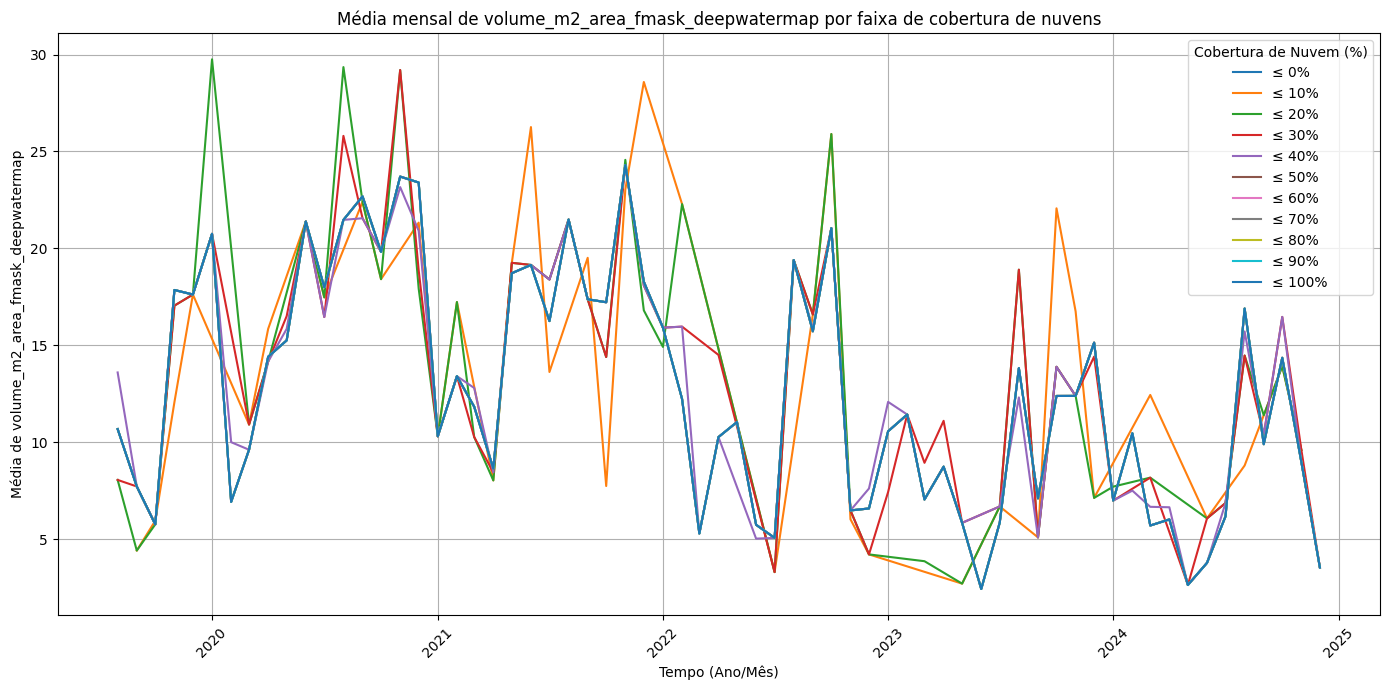

In [222]:
from scipy.ndimage import median_filter

df_resultado["volume_m2_area_fmask_deepwatermap_median"] = median_filter(
    df_resultado["volume_m2_area_fmask_deepwatermap"], size=30
)
plot_water_x_cloud_percent_over_time(
    df_resultado.loc[df_resultado["CLOUDY_PIXEL_PERCENTAGE"] <= 50],
    y_variable="volume_m2_area_fmask_deepwatermap",
)


In [201]:
df_resultado["z"]


49    -0.567924
50     0.486259
51    -0.981167
52    -1.304174
53     0.856501
         ...   
437    0.531421
438   -1.148154
439   -1.259803
440   -0.828913
441    0.122803
Name: z, Length: 393, dtype: float64

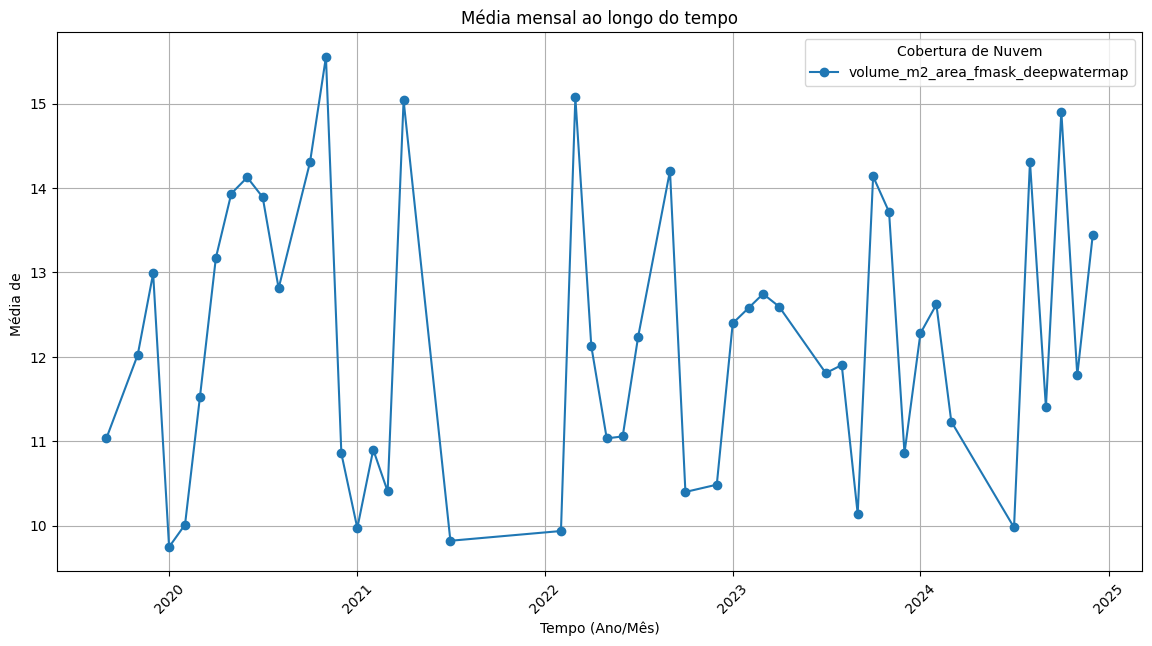

In [207]:
from scipy.stats import zscore

# Remove temporariamente os NaNs
df_resultado = df_resultado.dropna()

df_resultado["z"] = zscore(df_resultado["volume_m2_area_fmask_deepwatermap"])
df_resultado_filtrado = df_resultado[df_resultado["z"].abs() < 0.4]  # remove outliers com z > 2

plot_water_over_time(
    df_resultado_filtrado,
    y_variables=["volume_m2_area_fmask_deepwatermap"],
    labels=["volume_m2_area_fmask_deepwatermap"],
)
